# Tarea 3

La meta de esta tarea tratar de competirle a algoritmos de reducción de dimensionalidad, y encontrar las mejores features para clusterisar el dataset [MNIST](http://yann.lecun.com/exdb/mnist/) de digitos escritos a mano que se compone de imagenes de 28x28 pixeles, se separa en 60.000 imagenes de training y 10.000 de testing. Para efectos de la tarea sólo vamos a usar 10.000 imágenes.

### Detalles administrativos

La tarea es individual. Para la entrega, sube este notebook a canvas, el plazo para hacerlo es el **Viernes 4 de Octubre, a las 20:00 hrs**. Recuerda que tu notebook debe tener todas las celdas corridas.  

<div style="text-align: center;">
    <img src="https://i.ibb.co/GVnxyJ0/Design-1.png" alt="Design-1">
</div>

### Datos

Vamos a realizar la misma descarga al dataset MNIST que lo que hicimos para la semana 4. 

In [1]:
import numpy as np
import functools
import pandas as pd
import matplotlib.pyplot as plt



from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, accuracy_score


import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
#Tomamos el dataset y lo dividimos en X (los pixeles) e y (el número que es). 
#Recordemos que las imágenes son 28x28 = 784 pixeles
X, y = mnist['data'], mnist['target']
X_sample = X[60000:]
y_sample = y[60000:]
X_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 60000 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 59.8 MB


<Axes: >

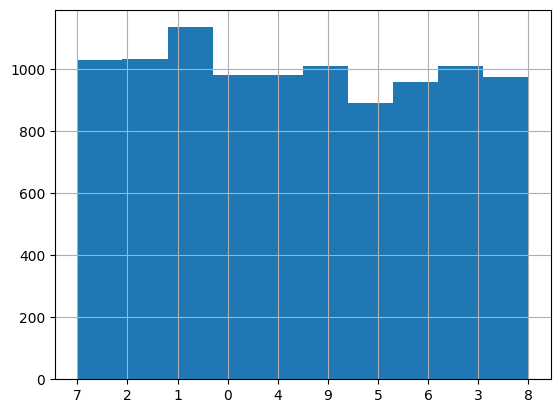

In [4]:
#Si bien los datos no están completamente balanceados, hay una buena mezcla de cada número en el dataset.
y_sample.hist()

## Parte 0.  Clusterizando en dos dimensiones

Ok! Tenemos los datos listos. O más o menos. La verdad es que si queremos hacer clusters con datos que tienen tantas dimensiones (768) vamos a necesitar harta capacidad de computo por lo que lo mejor que podemos hacer es reducir las dimensiones. En este caso vamos a reducirlas usando [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) y [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), dos algoritmos de reduccion de dimensionalidad. PCA lo vamos a ver en detalle más adelante en el curso, y vamos a hablar de algoritmos como t-SNE. 

En ambos casos vamos a probar como se ve todo en dos dimensiones, y vamos a comparar los clusteres obtenidos con las etiquetas reales que nos dicen qué número es cada imagen. Partimos aplicando PCA para generar, a parir de **X_sample**, un conjunto de vectores de solo dos dimensiones, que representan una forma de representar las 784 dimensiones en solo dos. De esta forma, el conjunto **vectors_pca_2** tiene exactamente la misma cantidad de vectores que **X_sample**, cada vector de un lado está en correspondencia con un vector del otro lado. 

In [5]:
# PCA dos dimensiones
pca_2d = PCA(n_components=2)
vectors_pca_2 = pca_2d.fit_transform(X_sample)



Ahora si estamos listos para hacer clustering con KMeans. En este caso sabemos que hay 10 digitos por lo que buscaremos 10 clusters.

In [6]:
kmeans = KMeans(n_clusters=10)
pca_clusters = kmeans.fit_predict(vectors_pca_2)

Veamos como nos queda esto si lo graficamos (esa es la gran gracia de reducir a dos dimensiones). 

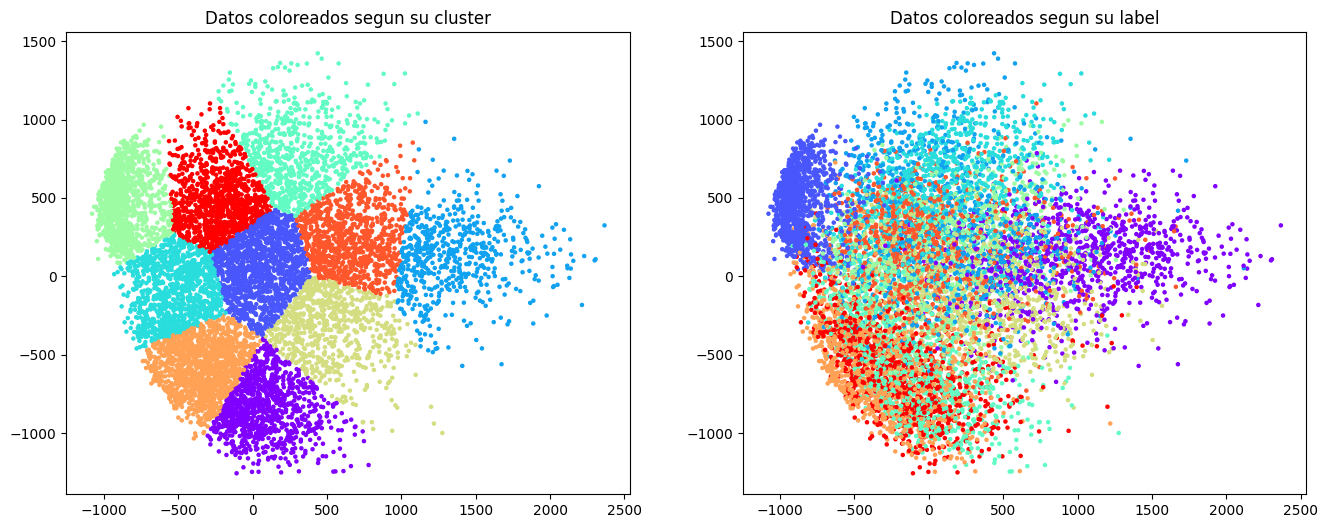

In [7]:
#Cambiamos la secuencia de categorias a enteros
labels = y_sample.astype(int)

fig, axes = plt.subplots(1, 2, dpi=100, figsize=(16,6))

axes[0].set_title("Datos coloreados segun su cluster")
axes[0].scatter(vectors_pca_2[:, 0], vectors_pca_2[:, 1], c=pca_clusters, cmap="rainbow", s=5)

axes[1].set_title("Datos coloreados segun su label")
axes[1].scatter(vectors_pca_2[:, 0], vectors_pca_2[:, 1], c=labels, cmap="rainbow", s=5)
plt.show()

Como puedes ver, hay algunos clusters que Kmeans toma bastante bien (por ejemplo, el verde de la izquierda, que corresponde al azul de la derecha). Antes de seguir, veamos como quedan los datos con otra forma de transformar **X_sample** en vectores 2D. 

In [8]:
# Y ahora tsne, esto se demora un poco (harto) más, alrededor de 1-5 minutos
tsne_2d = TSNE(n_components=2)
vectors_tsne_2 = tsne_2d.fit_transform(X_sample)

In [9]:
kmeans_tsne = KMeans(n_clusters=10)
tsne_clusters = kmeans_tsne.fit_predict(vectors_tsne_2)

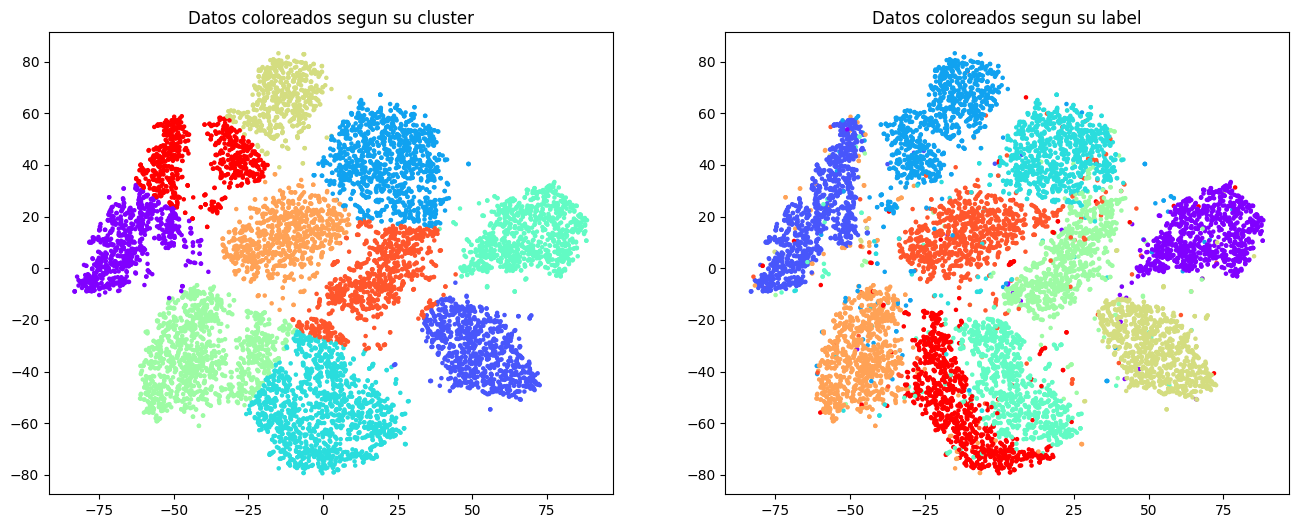

In [10]:
fig, axes = plt.subplots(1, 2, dpi=100, figsize=(16,6))

axes[0].set_title("Datos coloreados segun su cluster")
axes[0].scatter(vectors_tsne_2[:, 0], vectors_tsne_2[:, 1], c=tsne_clusters, cmap="rainbow", s=5)

axes[1].set_title("Datos coloreados segun su label")
axes[1].scatter(vectors_tsne_2[:, 0], vectors_tsne_2[:, 1], c=labels, cmap="rainbow", s=5)
plt.show()

Definitivamente se ven más claros los clusters y en general KMeans logra asignar a un mismo cluster los mismos digitos, pero se pueden ver que algunos digitos son separados en distintos clusters. Pronto veremos las ventajas de hacer diferentes reducciones de dimensionalidad, pero por ahora: sigamos con la tarea. 

### Pregunta a)

Normalmente no podemos usar a los algoritmos de clustering para clasificar, por que no tenemos información sobre la clase (clustering es no-supervisado). Sin embargo, ahora si tenemos información, así que podemos pedir el _accuracy_ tal como lo hacíamos con regresiones logísticas, KNN o árboles. Mira el accuracy score de este código. Es super bajo, comparable con un algoritmo aleatorio. Sin embargo, en la imagen de arriba vemos que (salvo algunos errores puntuales), los clusteres quedan relativamente bien. ¿Qué está pasando?

*Hay varias razones por las cuales podría tener mal accuracy, así que veré varias teorias*

In [11]:
# Teoria 1: El accuracy no es adecuado para para clustering solo para datos de prediccion. 
# Hay que ocupar silhouette_score, davies_bouldin_score que 
# estan hechos para esto.
silhouette = silhouette_score(X_sample, labels)
calinski_harabasz = calinski_harabasz_score(X_sample, labels)
davies_bouldin = davies_bouldin_score(X_sample, labels)

print(f"""
accuracy_score: {accuracy_score(labels,tsne_clusters)}
silhouette_score: {silhouette}
davies_bouldin_score: {davies_bouldin}
""")


accuracy_score: 0.006
silhouette_score: 0.04883591250809372
davies_bouldin_score: 3.8067764685140206



Vemos que los resultados dicen lo siguiente: 
**Silhouette Score:** Este valor sugiere que los clusters están mal divididos.
**Davies-Bouldin Score:** Dice que los clusters no están bien definidos.
Vamos a poner a prueva si efectivamente están mal divididos los clusters. 


In [12]:
#Teoria 2: Mala distribución por clusters


cluster_sizes = np.bincount(tsne_clusters)


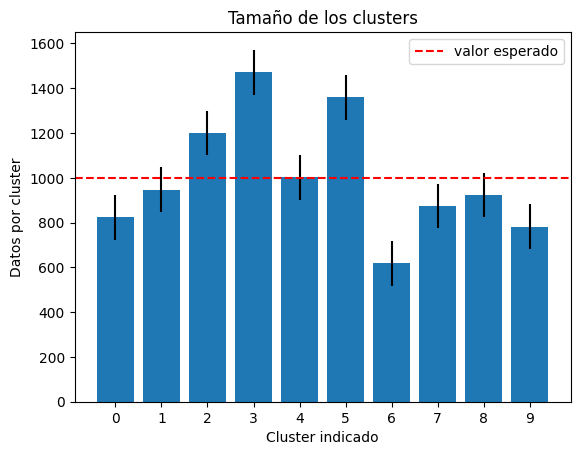

In [13]:

# Defino "esperado" como la cantidad de datos que debería haber por cluster.
esperado = len(tsne_clusters)/10

plt.bar(range(0, 10), cluster_sizes, yerr= 100)  # assuming 10 clusters
plt.axhline(y=esperado, color='r', linestyle='--', label='valor esperado')  # add a horizontal line at esperado height

plt.xlabel('Cluster indicado')
plt.ylabel('Datos por cluster')
plt.title('Tamaño de los clusters')

plt.xticks(range(0, 10)) 
plt.legend()
plt.show()

Vemos que la mayoría de los datos por cluster son de mucho mayor (cluster 4 y 7) o mucho menor(cluster 2, 8 y 9) al valor esperado. Incluyenso un más menos de 100 datos. Con esto puedo concluir al repartir mal los datos podría estar causando malas predicciones. 

## Parte 1.  Clusterizando en 4 dimensiones, comparación con silhouette score. 

Lo primero que vas a hacer es volver a realizar kmeans sobre los vectores **vectors_pca_4**, que tienen 4 dimensiones. Luego de eso, compararemos qué tan bueno es el clustering. 


In [14]:
pca_4d = PCA(n_components=4)
vectors_pca_4 = pca_4d.fit_transform(X_sample)

In [15]:
# Perform K-Means clustering on the reduced data

kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(vectors_pca_4)

En esta parte usaremos [`silhouette score`](https://es.wikipedia.org/wiki/Silhouette_(clustering)) y [`Dunn index`](https://en.wikipedia.org/wiki/Dunn_index), dos métricas para ver que tan buenos son los clústeres. 

### **Pregunta b)** 
Explica brevemente como funcionan estas dos métricas. Qué valores toman, qué significan? 



**Respuesta pregunta b):**  
El *Silhoutte score* calcula el error de clasificación para un valor haciendo el siguiente calculo: 


$$
\frac{b - a}{max(a,b)}
$$

donde (a) es la distancia promedio entre un punto y todos los demás puntos dentro del mismo cluster y (b): es la distancia promedio entre un punto y todos los puntos del cluster más cercano al que no pertenece.

Si se acerca a 1 significa que está bien elegido el cluster, si es 0 se encuentra en el limite, si es cerca a -1 está mal asignado.

In [16]:
# Calculate Silhouette Score
silhouette = silhouette_score(vectors_pca_4, labels)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.27113313744259676


*Esto significa que está más cerca a los bordes del cluster y podría no estar bien clasificado*

El *Dunn Index* calcula el radio entre los clusters y la máxima distancia dentro del cluster. Este valor estará entre 0 e infinito. Si es más cerca a 0 está mal dividido, mientras más grande, esta bien divido. 

In [17]:
# Calculate Dunn Index (using Davies-Bouldin Index as a proxy)
dunn = davies_bouldin_score(vectors_pca_4, labels)
print("Dunn Index:", dunn)

Dunn Index: 1.2408535088676451


*El valor es muy pequeño así que probablemente está mal clasificado*

### **Pregunta c)** 

Implementa o usa implementaciones del silhouette score y de Dunn index. Compara el resultado de kmeans sobre **vectors_pca_4**, sobre **vectors_pca_2** y sobre **vectors_tsne_2**. Usa silhouette score y Dunn index. ¿Qué puedes decir sobre el resultado? ¿Cuál de todas estas transformaciones resulta en un mejor clústering? 

In [18]:
### Respuesta pregunta c

sil_pca4 = silhouette_score(vectors_pca_4, labels)
sil_pca2 = silhouette_score(vectors_pca_2, labels)
sil_tsne2 = silhouette_score(vectors_tsne_2, labels)

dunn_pca4 = davies_bouldin_score(vectors_pca_4, labels)
dunn_pca2 = davies_bouldin_score(vectors_pca_2, labels)
dunn_tsne2 = davies_bouldin_score(vectors_tsne_2, labels)


In [19]:

max_sil = max(sil_pca4, sil_pca2, sil_tsne2)
min_dunn = min(dunn_pca4, dunn_pca2, dunn_tsne2)


In [20]:
if max_sil == sil_pca4:
    print(f"Según Silhoutte, el mejor es PCA4 con un valor de: {max_sil}")
elif max_sil == sil_pca2:
    print(f"Según Silhoutte, el mejor es PCA2 con un valor de: {max_sil}")
else:
    print(f"Según Silhoutte, el mejor es TSNE con un valor de: {max_sil}")

Según Silhoutte, el mejor es PCA2 con un valor de: 0.2798890558971095


In [21]:
if min_dunn == dunn_pca4:
    print(f"Según dunn, el mejor es PCA4 con un valor de: {min_dunn}")
elif min_dunn == dunn_pca2:
    print(f"Según dunn, el mejor es PCA2 con un valor de: {min_dunn}")
else:
    print(f"Según dunn, el mejor es TSNE2 con un valor de: {min_dunn}")

Según dunn, el mejor es PCA2 con un valor de: 1.1230898729814214


Vemos que después de las transformaciones, es mejor el **PCA2** para ambos casos. 

## Parte 2.  Feature selection

Como comentábamos, no podemos correr kmeans sobre 700+ dimensiones, y aún no comprendemos bien de qué forma se reduce la dimensionalidad. 

Por otro lado, dado que el silhouette score nos sirve para comparar clusteres con la misma dimensión, podemos pensar en el siguiente código, para elegir las mejores **4** dimensiones para clusterizar. 

    dim4 = []
    Para i entre 1 y 4: 
        Sea j la dimensión (entre 1 y 784, sin contar las dimensiones que ya están en dim4) tales que clusterizar con j y las dimensiones en dim4 entrega el mejor silhouette score. Agregar j a dim4. 
    



### Pregunta d) 
Implementa el pseudocódigo de arriba. Informa las 4 dimensiones, usa kmeans sobre el dataset reducido solo a esas 4 dimensiones (no usando PCA ni nada, simplemente borrando el resto). Llamale **vectors_dim4** a ese dataset. Clusteriza ese dataset, y compara con lo que obtuviste para **vectors_pca_4** (almacenado en **pca_4_clusters**). ¿Cuál tiene mejor silhouette score? 

In [22]:
def calculate_silhouette(value):
    unique_values = X_sample[value].nunique()
    if unique_values > 1:
        silhouette = silhouette_score(X_sample, X_sample[value])
        return {value: silhouette}
    else:
        return {value: None}  # or some other default value

In [23]:
vectors_dim4 = []
unique_columns = []
for col in X_sample.columns:
    if not any(X_sample[col].equals(X_sample[c]) for c in unique_columns):
        unique_columns.append(col)

print(f"Hay {len(unique_columns)} columnas que no se repiten")


Hay 668 columnas que no se repiten


In [24]:
chunk_size = 50 # adjust the chunk size based on your needs
chunks = [unique_columns[i:i + chunk_size] for i in range(0, len(unique_columns), chunk_size)]
len(chunks)

14

Cada celda dura 2 minutos y 13 segundos. No creo que sea razonable que el código duré 48 minutos, pero pueden descomentar cualquier chunk y debería funcionar. Ocuparé el primero y los dos últimos. esto debería durar 4 minutos más o menos

In [25]:
chunk_0 = {}
chunks[0]
for val in chunks[0]:
    chunk_0[val] = calculate_silhouette(val)


In [26]:
# chunk_1 = {}
# for val in chunks[1]:
#     chunk_1[val] = calculate_silhouette(val)


In [27]:
# chunk_2 = {}
# for val in chunks[2]:
#     chunk_2[val] = calculate_silhouette(val)



In [28]:
# chunk_3 = {}
# for val in chunks[3]:
#     chunk_3[val] = calculate_silhouette(val)




In [29]:

# chunk_4 = {}
# for val in chunks[4]:
#     chunk_4[val] = calculate_silhouette(val)




In [30]:

# chunk_5 = {}
# for val in chunks[5]:
#     chunk_5[val] = calculate_silhouette(val)



In [31]:

# chunk_6 = {}
# for val in chunks[6]:
#     chunk_6[val] = calculate_silhouette(val)





In [32]:
# chunk_7 = {}
# for val in chunks[7]:
#     chunk_7[val] = calculate_silhouette(val)




In [33]:

# chunk_8 = {}
# for val in chunks[8]:
#     chunk_8[val] = calculate_silhouette(val)




In [34]:

# chunk_9 = {}
# for val in chunks[9]:
#     chunk_9[val] = calculate_silhouette(val)



In [35]:
# chunk_10 = {}
# for val in chunks[10]:
#     chunk_10[val] = calculate_silhouette(val)





In [36]:
# chunk_11 = {}
# for val in chunks[11]:
#     chunk_11[val] = calculate_silhouette(val)




In [37]:

chunk_12 = {}
for val in chunks[12]:
    chunk_12[val] = calculate_silhouette(val)


In [38]:

chunk_13 = {}
for val in chunks[13]:
    chunk_13[val] = calculate_silhouette(val)


In [39]:
# Basado en el codigo de Aaron Hall disponible aquí: https://stackoverflow.com/questions/38987/how-do-i-merge-two-dictionaries-in-a-single-expression-in-python
def fuse_dicts(dict1, dict2):
    result = {}
    for key in set(dict1) | set(dict2):
        if key in dict1 and key in dict2:
            result[key] = dict1[key] + dict2[key]  # custom fusion logic
        elif key in dict1:
            result[key] = dict1[key]
        else:
            result[key] = dict2[key]
    return result


In [40]:
dict1 = chunk_0
dict2 = chunk_12
dict3 = chunk_13

flattened_dict = {}
for k, v in dict1.items():
    flattened_dict[k] = list(v.values())[0]
for k, v in dict2.items():
    flattened_dict[k] = list(v.values())[0]
for k,v in dict3.items():
    flattened_dict[k] = list(v.values())[0]


In [41]:


ordered_dict = dict(sorted(flattened_dict.items(), key=lambda item: float('-inf') if item[1] is None else item[1], reverse=True))

print(ordered_dict)

first_four_keys = list(ordered_dict.keys())[:4]

{'pixel778': np.float64(0.12684962894119634), 'pixel49': np.float64(0.06120756726934204), 'pixel733': np.float64(0.025416220665164628), 'pixel81': np.float64(0.02317904187244568), 'pixel34': np.float64(-0.0021715037363660363), 'pixel35': np.float64(-0.0021715037363660363), 'pixel36': np.float64(-0.0021715037363660363), 'pixel753': np.float64(-0.00432823827012239), 'pixel37': np.float64(-0.01621813062149526), 'pixel763': np.float64(-0.017260686175107703), 'pixel38': np.float64(-0.02449470704473555), 'pixel704': np.float64(-0.02981809631341198), 'pixel48': np.float64(-0.033193776426761704), 'pixel80': np.float64(-0.03353854716058789), 'pixel726': np.float64(-0.0381149632316353), 'pixel62': np.float64(-0.043017898764881775), 'pixel698': np.float64(-0.043366244450123055), 'pixel777': np.float64(-0.04352759334315907), 'pixel764': np.float64(-0.05361615980201021), 'pixel89': np.float64(-0.056180145158414484), 'pixel776': np.float64(-0.05700463140959826), 'pixel734': np.float64(-0.06380419803

In [42]:
vectors_dim4 = []
for k in first_four_keys:
    vectors_dim4.append(X_sample[k])

df = pd.DataFrame(vectors_dim4).T


In [43]:
kmeans_dim4 = KMeans(n_clusters=4, random_state=42)
labels = kmeans_dim4.fit_predict(df)
silhouette_dim4 = silhouette_score(df, labels)
print(f"Silhouette score para vectors_dim4: {silhouette_dim4:.3f}")

Silhouette score para vectors_dim4: 1.000


In [44]:
pca_4d = PCA(n_components=4)
vectors_pca_4 = pca_4d.fit_transform(X_sample)
kmeans = KMeans(n_clusters=4)
labels_pca4 = kmeans.fit_predict(vectors_pca_4)
silhouette_pca4 = silhouette_score(X_sample, labels)
print(f"Silhouette score para pca_dim4: {silhouette_pca4:.3f}")


Silhouette score para pca_dim4: 0.028


Podemos concluir que es mejor el silhouette score para vector_dim4

### Pregunta e) 
Ahora realiza una comparación visual eligiendo las primeras dos dimensiones de **vectors_4dim**, tal como lo hicimos arriba con los clusteres realizados con dos dimensiones. ¿Qué está pasando? ¿Puedes ver una limitación del silhouette score?

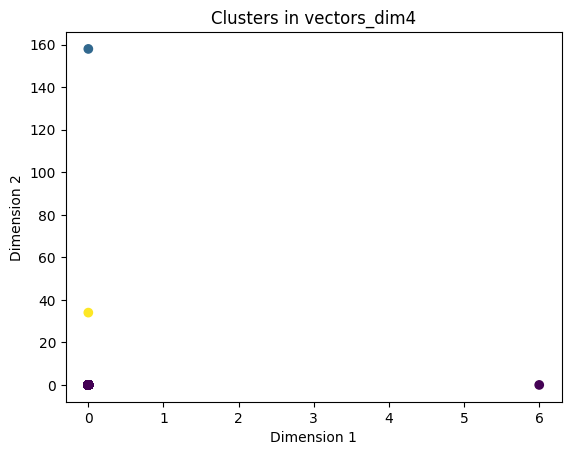

In [45]:
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Clusters in vectors_dim4")
plt.show()

Tiene muy pocos valores, no creo que sea un buen método para hacer predicciones

### Pregunta f) 
Finalmente, vuelve a correr ese pseudocódigo pero tomando ahora la dimensión que mejora el Dunn index. Vuelve a realizar una comparación visual, como en la pregunta e). ¿Ves alguna diferencia con lo obtenido para el código que tomaba las 4 mejores dimensiones según el silhouette score?

In [46]:
def calculate_dunn(value):
    unique_values = X_sample[value].nunique()
    if unique_values > 1:
        dunn = davies_bouldin_score(X_sample, X_sample[value])
        return {value: dunn}
    else:
        return {value: None}  # or some other default value

Repetiré un proceso parecido donde tomaré los primero tres y los últimos tres porque son entre 3 y 4 segundos.

In [47]:
chunk_0 = {}
chunks[0]
for val in chunks[0]:
    chunk_0[val] = calculate_dunn(val)


In [48]:
chunk_1 = {}
for val in chunks[1]:
    chunk_1[val] = calculate_dunn(val)


In [49]:
chunk_2 = {}
for val in chunks[2]:
    chunk_2[val] = calculate_dunn(val)

In [50]:
chunk_11 = {}
for val in chunks[11]:
    chunk_11[val] = calculate_dunn(val)

In [51]:
chunk_12 = {}
for val in chunks[12]:
    chunk_12[val] = calculate_dunn(val)

In [52]:
chunk_13 = {}
for val in chunks[13]:
    chunk_13[val] = calculate_dunn(val)

In [53]:
def flater_dict(dictionary):
    flattened_dict = {}
    for k, v in dictionary.items():
        flattened_dict[k] = list(v.values())[0]
    return flattened_dict

In [54]:
total = {}
for k in [chunk_0, chunk_1, chunk_2, chunk_11, chunk_12, chunk_13]:
    total.update(flater_dict(k))
total

{'pixel1': None,
 'pixel34': np.float64(0.9950755088717635),
 'pixel35': np.float64(0.9950755088717635),
 'pixel36': np.float64(0.9950755088717635),
 'pixel37': np.float64(0.9578085928876957),
 'pixel38': np.float64(1.0876829881656545),
 'pixel39': np.float64(0.9154649407925354),
 'pixel40': np.float64(0.9696631805400371),
 'pixel41': np.float64(0.9821493525176239),
 'pixel42': np.float64(1.181477730863773),
 'pixel43': np.float64(1.0744716553808864),
 'pixel44': np.float64(1.0561685834929255),
 'pixel45': np.float64(1.0014569291323347),
 'pixel46': np.float64(1.0310665344290115),
 'pixel47': np.float64(1.0129944698171638),
 'pixel48': np.float64(0.9583328648335467),
 'pixel49': np.float64(0.8619864434447878),
 'pixel62': np.float64(0.9462091262836587),
 'pixel63': np.float64(1.2378693070844045),
 'pixel64': np.float64(0.9132166385880133),
 'pixel65': np.float64(1.1456416740064148),
 'pixel66': np.float64(1.1527997647996622),
 'pixel67': np.float64(1.2721000103102504),
 'pixel68': np.f

In [55]:


ordered_dict = dict(sorted(total.items(), key=lambda item: float('-inf') if item[1] is None else item[1], reverse=True))

first_four_keys = list(total.keys())[1:5]

print(first_four_keys)

['pixel34', 'pixel35', 'pixel36', 'pixel37']


In [56]:
vectors_dim4 = []
for k in first_four_keys:
    vectors_dim4.append(X_sample[k])

df = pd.DataFrame(vectors_dim4).T

In [57]:
kmeans_dim4 = KMeans(n_clusters=4, random_state=42)
labels = kmeans_dim4.fit_predict(df)
cal_dim4 = davies_bouldin_score(df, labels)
print(f"Dunn score para vectors_dim4: {cal_dim4:.3f}")

Dunn score para vectors_dim4: 0.000


In [58]:
pca_4d = PCA(n_components=4)
vectors_pca_4 = pca_4d.fit_transform(X_sample)
kmeans = KMeans(n_clusters=4)
labels_pca4 = kmeans.fit_predict(vectors_pca_4)
cal_pca4 = davies_bouldin_score(X_sample, labels)
print(f"Dunn score para pca_dim4: {cal_pca4:.3f}")


Dunn score para pca_dim4: 0.958


Resulta en este caso; actua peor al editarlo así en vez de pca_4.

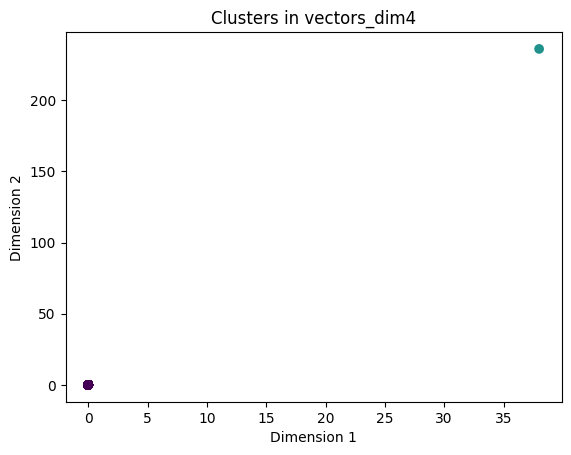

In [59]:
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Clusters in vectors_dim4")
plt.show()

Hay aún menos valores, así que por eso debe ser peor como es que funciona